In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from PIL import Image
import numpy as np
import sys

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms
import torchvision.models as models

%matplotlib inline

print("mpl backend: ", plt.get_backend())

mpl backend:  module://ipykernel.pylab.backend_inline


In [2]:
torch.cuda.set_device(3)

In [3]:
vgg16_pretrained = models.vgg16(pretrained=True).eval().cuda()

class VGG16_conv(torch.nn.Module):
    def __init__(self, n_classes):
        super(VGG16_conv, self).__init__()
        # VGG16 (using return_indices=True on the MaxPool2d layers)
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv5
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True))
        self.feature_outputs = [0]*len(self.features)
        self.pool_indices = dict()

        self.classifier = vgg16_pretrained.classifier
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            print("initializing layer {}: {}".format(i, layer))
            try:
                self.features[i].weight.data = layer.weight.data
                self.features[i].bias.data = layer.bias.data
            except:
                continue

    def get_conv_layer_indices(self):
        return [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [4]:
class VGG16_deconv(torch.nn.Module):
    def __init__(self):
        super(VGG16_deconv, self).__init__()
        self.relu = torch.nn.ReLU()
        
        self.conv2DeconvIdx = {0:17, 2:16, 5:14, 7:13, 10:11, 12:10, 14:9, 17:7, 19:6, 21:5, 24:3, 26:2, 28:1}
        self.conv2DeconvBiasIdx = {0:16, 2:14, 5:13, 7:11, 10:10, 12:9, 14:7, 17:6, 19:5, 21:3, 24:2, 26:1, 28:0}
        self.unpool2PoolIdx = {15:4, 12:9, 8:16, 4:23, 0:30}
        
        self.deconv_features = torch.nn.Sequential(
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(128, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(128, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(64, 3, 3, padding=1))

        # not the most elegant, given that I don't need the MaxUnpools here
        self.deconv_first_layers = torch.nn.ModuleList([
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 3, 3, padding=1) ])

        self._initialize_weights()

    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, torch.nn.Conv2d):
                self.deconv_features[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                biasIdx = self.conv2DeconvBiasIdx[i]
                if biasIdx > 0:
                    self.deconv_features[biasIdx].bias.data = layer.bias.data
                

    def forward(self, x, layer_number, map_number, pool_indices):
        start_idx = self.conv2DeconvIdx[layer_number]
        if not isinstance(self.deconv_first_layers[start_idx], torch.nn.ConvTranspose2d):
            raise ValueError('Layer '+str(layer_number)+' is not of type Conv2d')
        # set weight and bias
        self.deconv_first_layers[start_idx].weight.data = self.deconv_features[start_idx].weight[map_number].data[None, :, :, :]
        self.deconv_first_layers[start_idx].bias.data = self.deconv_features[start_idx].bias.data        
        # first layer will be single channeled, since we're picking a particular filter
        output = self.deconv_first_layers[start_idx](x)

        # transpose conv through the rest of the network
        for i in range(start_idx+1, len(self.deconv_features)):
            if isinstance(self.deconv_features[i], torch.nn.MaxUnpool2d):
                output = self.deconv_features[i](output, pool_indices[self.unpool2PoolIdx[i]])
            else:
                output = self.deconv_features[i](output)
                output = self.relu(output)
        return output

In [5]:
from math import sqrt, ceil

def vis_layer(activ_map, sh):
    plt.clf()
    plt.subplot(121)
    h = np.int(np.sqrt(sh[1]))
    plt.xticks([i*sh[3]+i+sh[3]/2 for i in range(h)], [i for i in range(h)])
    plt.yticks([i*sh[2]+i+sh[2]/2 for i in range(h)], [i for i in range(h)])
    plt.grid(False)
    plt.imshow(activ_map[:,:,0], cmap='gray')

def decon_img(layer_output):
    if isinstance(layer_output, np.ndarray):
        raw_img = layer_output[0].transpose(1,2,0)
    else:
        if isinstance(layer_output, torch.autograd.Variable):
            raw_img = layer_output.data.cpu().numpy()[0].transpose(1,2,0)
        else:
            raw_img = layer_output.cpu().numpy()[0].transpose(1,2,0)
    img = (raw_img-raw_img.min())/(raw_img.max()-raw_img.min())*255
    img = img.astype(np.uint8)
    return img


def vis_grid(Xs, im=0):
    """ visualize a grid of images """
    (N, C, H, W) = Xs.shape
    A = int(ceil(sqrt(C)))
    G = np.ones((A*H+A, A*W+A, 1), Xs.dtype)
    G *= np.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < C:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, 0] = Xs[im, n,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G
  

In [6]:
n_classes = 1000 # using ImageNet pretrained weights

vgg16_c = VGG16_conv(n_classes).cuda()
conv_layer_indices = vgg16_c.get_conv_layer_indices()
print('VGG16 model:')
print(vgg16_c)

tmp = "".join(open("../labels.txt", 'r').readlines()).replace("\n", "")
labeldict = eval(tmp)

initializing layer 0: Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 1: ReLU(inplace)
initializing layer 2: Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 3: ReLU(inplace)
initializing layer 4: MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 5: Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 6: ReLU(inplace)
initializing layer 7: Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 8: ReLU(inplace)
initializing layer 9: MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 10: Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 11: ReLU(inplace)
initializing layer 12: Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 13: ReLU(inplace)
initializing layer 14: Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
tr_feed = transforms.Compose([
          transforms.Scale(224),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize,
          ])

tr_debug = transforms.Compose([
           transforms.Scale(224),
           transforms.CenterCrop(224),
           np.asarray
           ])

/home/lestsovba/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


/home/lestsovba/dataset/imagenet/ImageNet_Utils/n02096294/n02096294_urlimages/Yorkshire%20Terrier.jpg


NameError: name 'data' is not defined

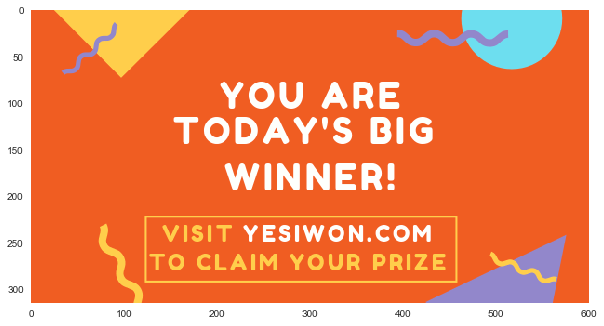

In [3]:
imname="/home/lestsovba/dataset/imagenet/ImageNet_Utils/n02096294/n02096294_urlimages/Yorkshire%20Terrier.jpg"
with open(imname, 'rb') as f:
    print(imname)
    img = Image.open(f)
    plt.figure(figsize=(10,8))
    #plt.title(name)
    plt.grid(False)
    plt.imshow(img)
    if data.transform:
        img = data.transform(img)
    img = torch.stack([img.clone(), img.clone(), img.clone()], dim=1)
    print(img.shape)

In [8]:
import re
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader

In [9]:
class ImagenetDataset(Dataset):
    def __init__(self, filespath, labelspath, transform=None):
        super(Dataset, self).__init__()
        
        self.transform = transform
        self.filespath = filespath
        self.labelspath = labelspath
        
        self.regexp = re.compile("(n[0-9]+)")
        self.files = OrderedDict()

        with open(filespath, 'r') as f, open(labelspath, 'r') as g:
            self.labels = {i[0]:(int(i[1]), i[2]) for i in [i.split() for i in g.readlines()]}
            for i in f.read().splitlines():
                 self.files[i] = self.regexp.search(i).group(1)
        
        self.keys = list(self.files.keys())
        self.files = OrderedDict((k, self.files[k]) for k in self.keys)
        
        
        n_classes = 1000 # using ImageNet pretrained weights

        tmp = "".join(open("../labels.txt", 'r').readlines()).replace("\n", "")
        self.labeldict = eval(tmp)
                
    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        self.idx = idx
        imname = self.keys[idx]
        wordnet_class = self.files[imname]
        num_class = self.labels[wordnet_class][0]
        human_class = self.labels[wordnet_class][1]
        
        with open(imname, 'rb') as f:
            img = Image.open(f)
            if self.transform:
                img = self.transform(img)
        if img.shape[0] != 3:
            img = torch.stack([img.clone(), img.clone(), img.clone()], dim=1).squeeze()
        
        return img, num_class, wordnet_class, human_class, imname

In [10]:
filespath = "/home/lestsovba/dataset/imagenet/ImageNet_Utils/files.txt"
labelspath = "/home/lestsovba/dataset/imagenet/valid_labels.txt"

data = ImagenetDataset(filespath, labelspath, tr_feed)
batchsize = 4
dataloader = DataLoader(data, batch_size=batchsize,
                        shuffle=True, num_workers=1)

In [16]:
for i, batch in enumerate(dataloader):
    #print(i)
    #if i > 1:
    #    break
    for img, _, _, name, imname in zip(*batch):
        #plt.figure(figsize=(10,8))
        #plt.title(name)
        #plt.grid(False)
        img = img.numpy().transpose(1,2,0)
        #plt.imshow(img)

AttributeError: Traceback (most recent call last):
  File "/home/lestsovba/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/lestsovba/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-14-fd349add1983>", line 37, in __getitem__
    img = Image.open(f)
  File "/home/lestsovba/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2291, in open
    from . import ImageColor
  File "/home/lestsovba/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 366, in preinit
    from . import BmpImagePlugin
  File "/home/lestsovba/anaconda3/lib/python3.6/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/lestsovba/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py", line 1815, in <module>
    Image.register_extensions(TiffImageFile.format, [".tif", ".tiff"])
AttributeError: module 'PIL.Image' has no attribute 'register_extensions'


In [320]:
for k, v in data.labeldict.items():
    print(k, v)

0 tench, Tinca tinca
1 goldfish, Carassius auratus
2 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3 tiger shark, Galeocerdo cuvieri
4 hammerhead, hammerhead shark
5 electric ray, crampfish, numbfish, torpedo
6 stingray
7 cock
8 hen
9 ostrich, Struthio camelus
10 brambling, Fringilla montifringilla
11 goldfinch, Carduelis carduelis
12 house finch, linnet, Carpodacus mexicanus
13 junco, snowbird
14 indigo bunting, indigo finch, indigo bird, Passerina cyanea
15 robin, American robin, Turdus migratorius
16 bulbul
17 jay
18 magpie
19 chickadee
20 water ouzel, dipper
21 kite
22 bald eagle, American eagle, Haliaeetus leucocephalus
23 vulture
24 great grey owl, great gray owl, Strix nebulosa
25 European fire salamander, Salamandra salamandra
26 common newt, Triturus vulgaris
27 eft
28 spotted salamander, Ambystoma maculatum
29 axolotl, mud puppy, Ambystoma mexicanum
30 bullfrog, Rana catesbeiana
31 tree frog, tree-frog
32 tailed frog, bell toad, ribbed to

702 parallel bars, bars
703 park bench
704 parking meter
705 passenger car, coach, carriage
706 patio, terrace
707 pay-phone, pay-station
708 pedestal, plinth, footstall
709 pencil box, pencil case
710 pencil sharpener
711 perfume, essence
712 Petri dish
713 photocopier
714 pick, plectrum, plectron
715 pickelhaube
716 picket fence, paling
717 pickup, pickup truck
718 pier
719 piggy bank, penny bank
720 pill bottle
721 pillow
722 ping-pong ball
723 pinwheel
724 pirate, pirate ship
725 pitcher, ewer
726 plane, carpenter's plane, woodworking plane
727 planetarium
728 plastic bag
729 plate rack
730 plow, plough
731 plunger, plumber's helper
732 Polaroid camera, Polaroid Land camera
733 pole
734 police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
735 poncho
736 pool table, billiard table, snooker table
737 pop bottle, soda bottle
738 pot, flowerpot
739 potter's wheel
740 power drill
741 prayer rug, prayer mat
742 printer
743 prison, prison house
744 projectile, missile
7

In [24]:
sm = nn.Softmax()

for i, batch in enumerate(dataloader):
    if i > 1:
        break
    print("\nBatch {}:".format(i))
    datatensor = batch[0]
    img_var = Variable(datatensor.cuda(), requires_grad=False)
    
    conv_out = vgg16_c.forward(img_var)
    res = sm(conv_out)
    prob, ind = torch.topk(res, 5)

    for image in range(batchsize):
        print("Pic:", image)
        for i in range(ind.size()[1]):
            print(" "*4, data.labeldict[ind[image, i].data[0]], " : ", prob[image, i].data[0])


Batch 0:
Pic: 0
     ibex, Capra ibex  :  0.8917403817176819
     gazelle  :  0.08415620774030685
     impala, Aepyceros melampus  :  0.023634660989046097
     hartebeest  :  0.00019913978758268058
     bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis  :  0.0001774520060280338
Pic: 1
     kit fox, Vulpes macrotis  :  0.9310879707336426
     red fox, Vulpes vulpes  :  0.055662017315626144
     grey fox, gray fox, Urocyon cinereoargenteus  :  0.007042611949145794
     red wolf, maned wolf, Canis rufus, Canis niger  :  0.0028995778411626816
     coyote, prairie wolf, brush wolf, Canis latrans  :  0.002082312246784568
Pic: 2
     ibex, Capra ibex  :  0.8930143713951111
     impala, Aepyceros melampus  :  0.04302646219730377
     gazelle  :  0.040311869233846664
     dhole, Cuon alpinus  :  0.01004860084503889
     dingo, warrigal, warragal, Canis dingo  :  0.004197689704596996
Pic: 3
     tabby, tabby cat  :  0.7332180738449097
     tiger cat

/home/lestsovba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


0.15645542740821838
     Egyptian cat  :  0.10182923823595047
     crossword puzzle, crossword  :  0.0012247998965904117
     wood rabbit, cottontail, cottontail rabbit  :  0.0006870940560474992

Batch 1:
Pic: 0
     Siberian husky  :  0.5870905518531799
     malamute, malemute, Alaskan malamute  :  0.2998010516166687
     Eskimo dog, husky  :  0.07330206781625748
     Cardigan, Cardigan Welsh corgi  :  0.005921326112002134
     sleeping bag  :  0.005853322800248861
Pic: 1
     English setter  :  0.4893762171268463
     Bedlington terrier  :  0.1429176926612854
     Old English sheepdog, bobtail  :  0.08447122573852539
     standard poodle  :  0.05315571650862694
     soft-coated wheaten terrier  :  0.03813772276043892
Pic: 2
     Siberian husky  :  0.636685311794281
     Eskimo dog, husky  :  0.2575814127922058
     malamute, malemute, Alaskan malamute  :  0.1039280891418457
     Border collie  :  0.00028269621543586254
     kelpie  :  0.00023181353753898293
Pic: 3
     kit fox, Vulpe

In [25]:
layer = 10
im = 2

(4, 256, 56, 56)
(256, 56, 56)
(40, 23, 25)           8    2    59.00260543823242
(134, 22, 25)          6    8    60.483402252197266
(242, 22, 26)          2    15   60.86050033569336
(242, 22, 36)          2    15   61.50544357299805
(134, 22, 35)          6    8    76.44426727294922


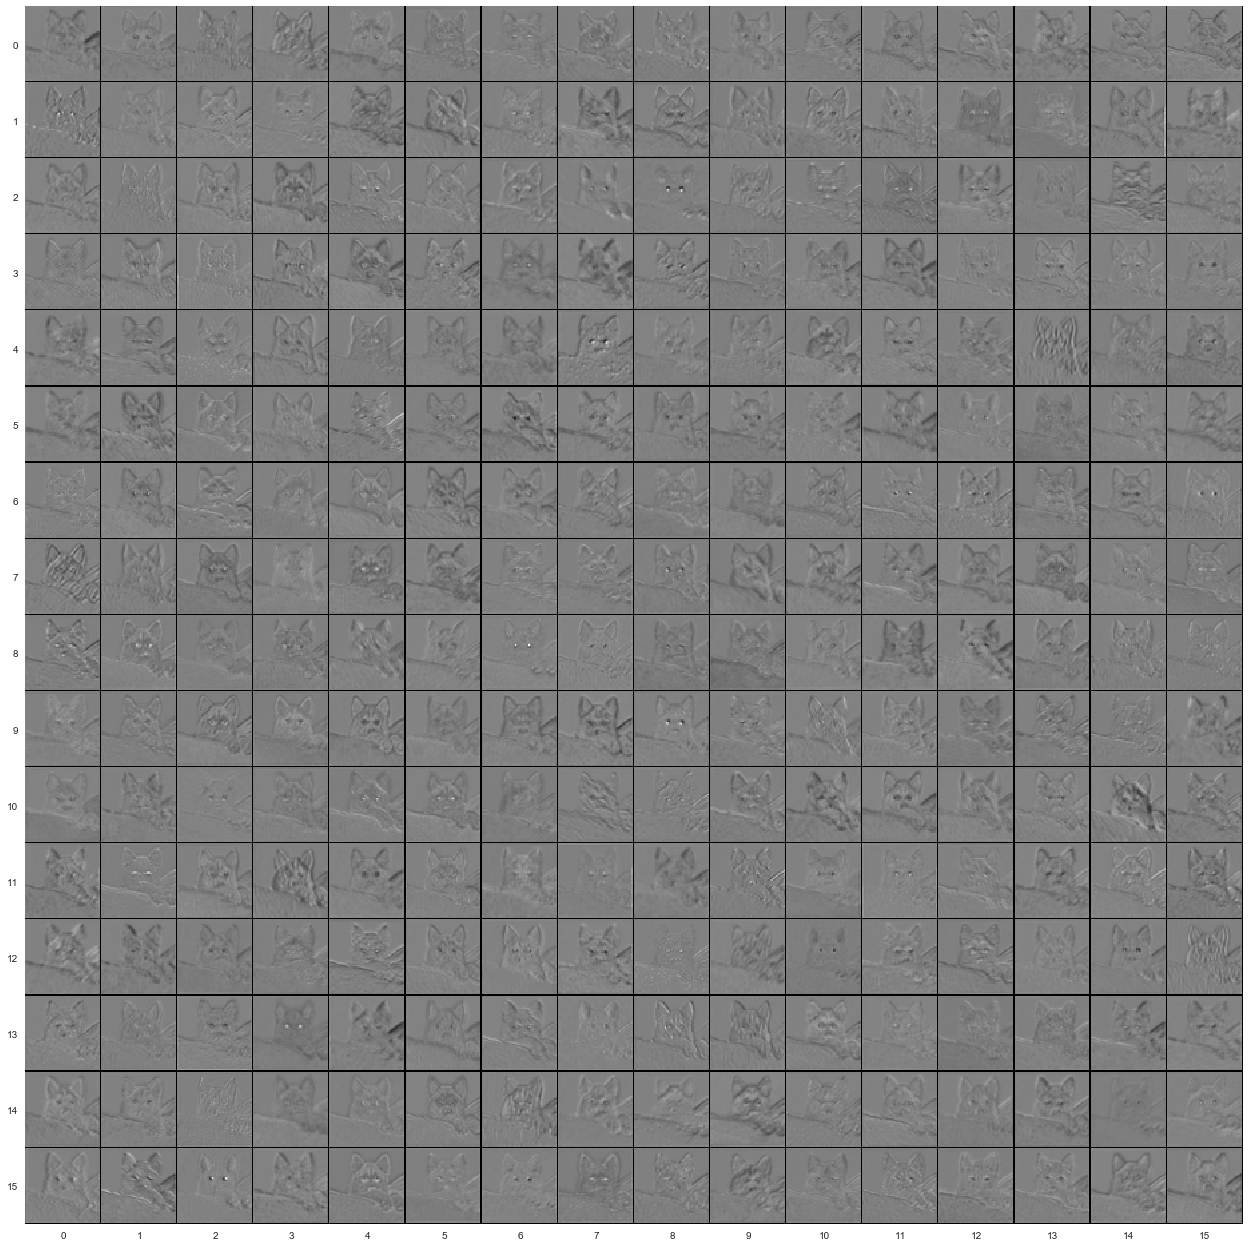

In [26]:
plt.figure(figsize=(48,48))

activ_map = vgg16_c.feature_outputs[layer].data.cpu().numpy()
activ_map_shape = activ_map.shape
k_filt = activ_map_shape[1]
print(activ_map_shape)
activ_map_grid = vis_grid(activ_map, im)
vis_layer(activ_map_grid, activ_map_shape)
activ_map_shape1 = activ_map_shape[1:]
print(activ_map_shape1)

ix = np.unravel_index(activ_map[im].argsort(axis=None)[-5:], activ_map_shape1)
for i in zip(*ix):
    print("{: <22} {: <4} {: <4} {}".format(str(i), 
                                            int(i[0] % np.sqrt(k_filt)),
                                            int(i[0] / np.sqrt(k_filt)), 
                                            activ_map[im][i]))

In [27]:
activ_map = activ_map.transpose(1,2,3,0)

In [32]:
m = 134

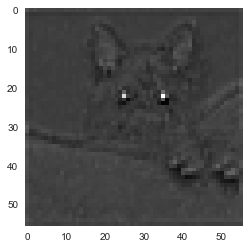

In [33]:
G=activ_map[m,:,:,im]
maxg = G.max()
ming = G.min()
G = (G - ming)/(maxg-ming)
plt.grid(False)
plt.imshow(G, cmap='gray')

In [16]:
vgg16_d = VGG16_deconv().cuda()

In [80]:
vgg16_c.feature_outputs[layer].size()

torch.Size([2, 256, 56, 56])

Maps in layer 10: 256
Map 162:
torch.Size([1, 3, 224, 224])


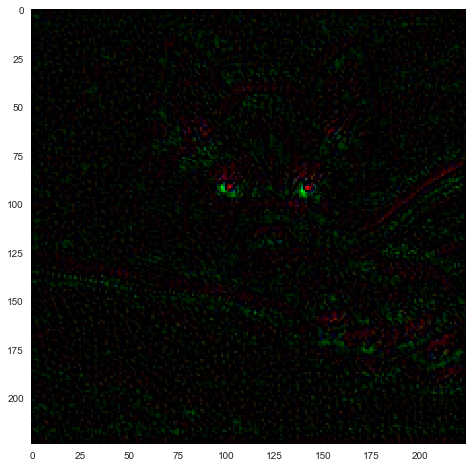

In [42]:
n_maps = activ_map.shape[0]
print("Maps in layer {}:".format(layer), n_maps)


_, map_x_dim, map_y_dim, _ = activ_map.shape
map_img_x_dim, map_img_y_dim, _ = activ_map_grid.shape
x_step = map_img_x_dim//(map_x_dim+1)


#layer = 12
x_index = 6
y_index = 0
map_idx = int(x_step*x_index + y_index)

map_idx = 162

print("Map {}:".format(map_idx))

if map_idx >= n_maps:
    print('Invalid map selected')

pool_ind_single = {k:v[[im],...] for k, v in vgg16_c.pool_indices.items()}


decon = vgg16_d(vgg16_c.feature_outputs[layer][im][map_idx][None,None,:,:], 
                layer, 
                map_idx, 
                pool_ind_single)
print(decon.size())
plt.figure(figsize=(8,8))
img = decon_img(decon)
plt.grid(False)
plt.imshow(img)


In [94]:
num_filt = vgg16_c.feature_outputs[layer].data.shape[1]
decon_maps = []

In [43]:
for i in range(num_filt):
    decon = vgg16_d(vgg16_c.feature_outputs[layer][:, i].unsqueeze(1), layer, i, vgg16_c.pool_indices).data
    decon -= decon.mean()
    decon /= decon.std()
    #decon = decon.cpu().numpy()
    decon_maps.append(decon)

In [44]:
dist = np.zeros((num_filt, num_filt), dtype=np.float32)
#num_els = float(np.prod(decon_maps.shape))

#for img in range(batchsize):
for i in range(num_filt):
    for j in range(i):
        dist[i, j] = torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)#/num_els

In [45]:
with open("reconstructions.npy", 'wb') as f:
    np.save(f, dist)

In [46]:
with open("reconstructions.npy", 'rb') as f:
    dist = np.load(f)

In [47]:
for i in range(num_filt):
    for j in range(num_filt-i):
        dist[i, i+j] = np.inf

In [19]:
def get_sorts(dist):
    sorts = OrderedDict()
    for i, ind in enumerate(dist.argsort(axis=None)):
        indices = np.unravel_index(ind, dist.shape)
        indices = tuple(sorted(indices, reverse=True))
        if not indices in sorts and dist[indices] != np.inf and dist[indices] != 0:
            sorts[indices] = dist[indices]
            
    return sorts

In [52]:
top = 8
sorts = get_sorts(dist)
topsorts = OrderedDict(list(sorts.items())[:top])
topsorts

OrderedDict([((82, 62), 83.492813),
             ((89, 17), 87.409508),
             ((89, 62), 91.84552),
             ((95, 73), 92.06443),
             ((89, 82), 94.752235),
             ((62, 17), 96.931572),
             ((62, 61), 99.200989),
             ((99, 89), 99.33532)])

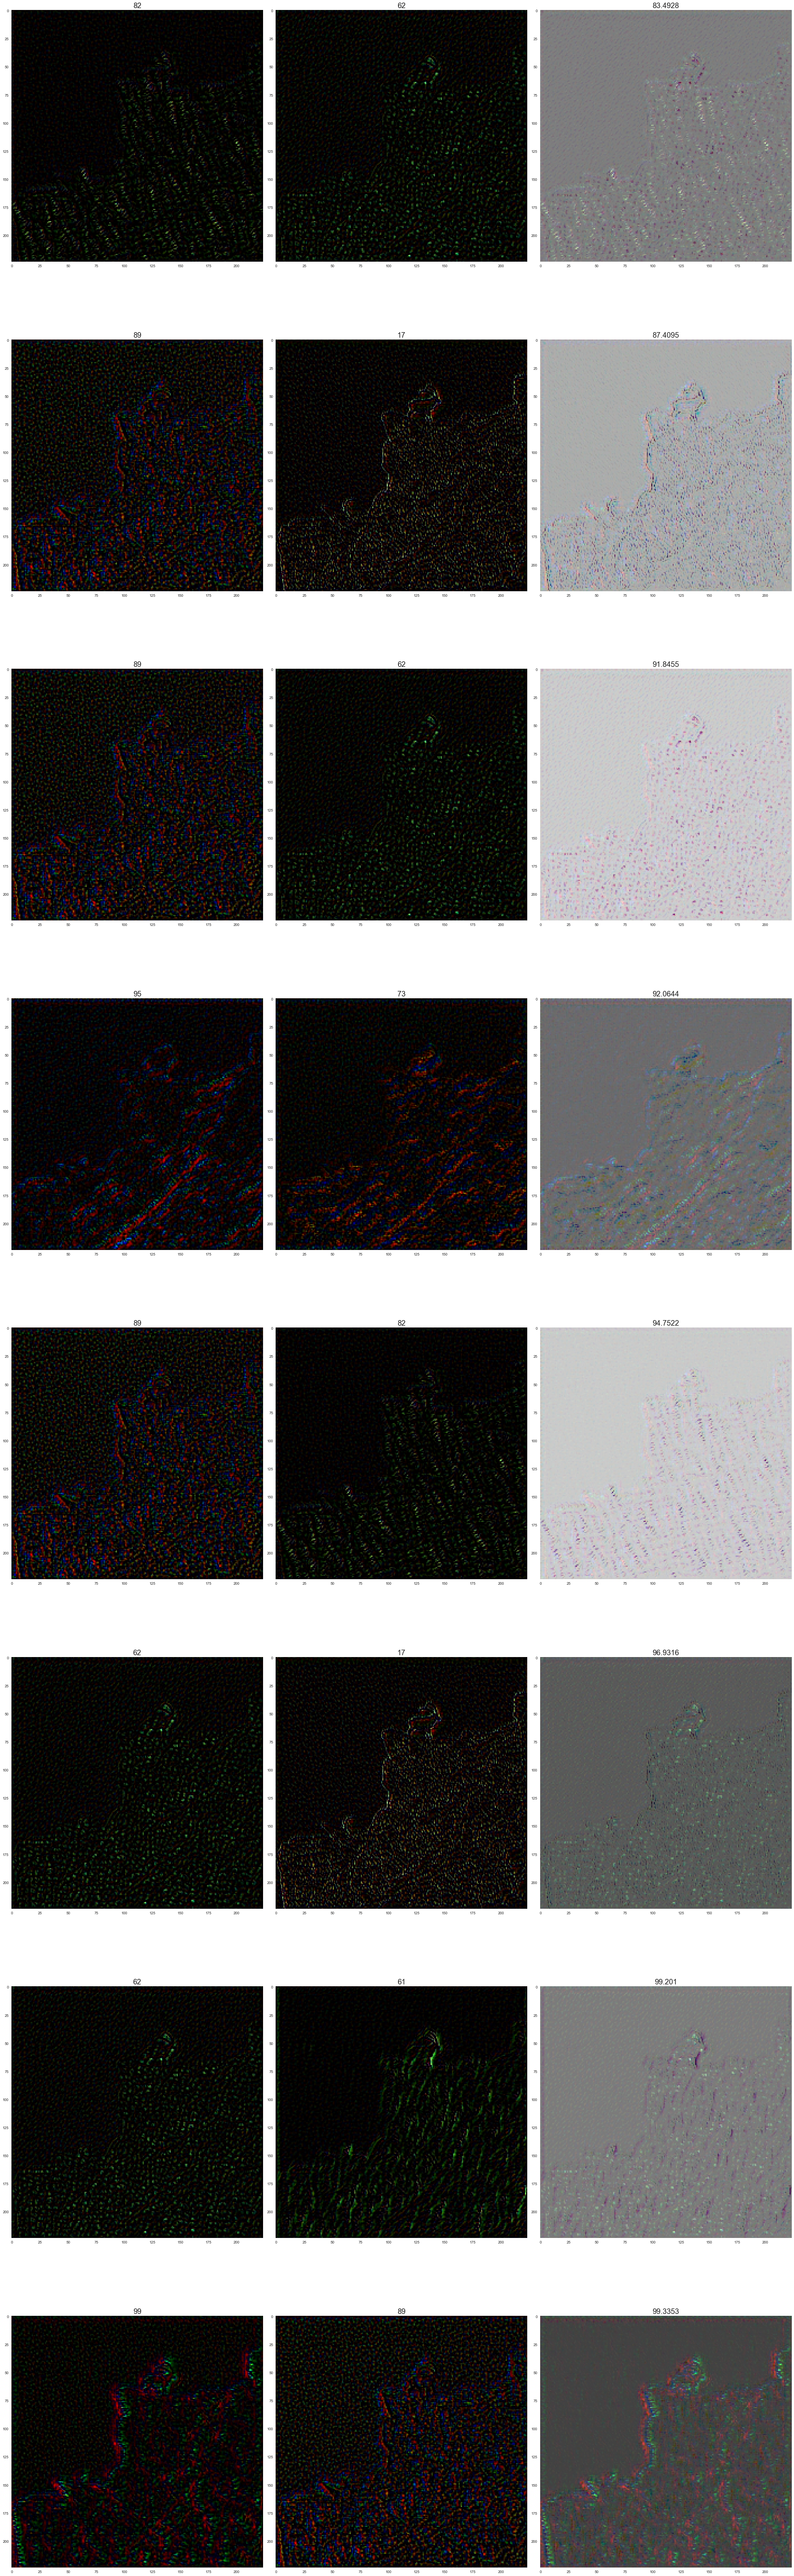

In [54]:
top = 8
f, axarr = plt.subplots(nrows=len(topsorts), ncols=3,  figsize=(30, 100))

for ind, ((i, j), diff) in enumerate(list(topsorts.items())[:top]):
    img = decon_img(decon_maps[i])
    axarr[ind, 0].set_title(str(i))
    axarr[ind, 0].title.set_fontsize(20)
    axarr[ind, 0].imshow(img)

    img = decon_img(decon_maps[j])
    axarr[ind, 1]
    axarr[ind, 1].set_title(str(j))
    axarr[ind, 1].title.set_fontsize(20)
    axarr[ind, 1].imshow(img)
    
    img = decon_img(decon_maps[i]-decon_maps[j])
    axarr[ind, 2].set_title(str(diff))
    axarr[ind, 2].title.set_fontsize(20)
    axarr[ind, 2].imshow(img)
    
    axarr[ind, 0].grid(False)
    axarr[ind, 1].grid(False)
    axarr[ind, 2].grid(False)

plt.grid(False)
plt.tight_layout()
plt.show()

In [51]:
x = list(sorts.values())

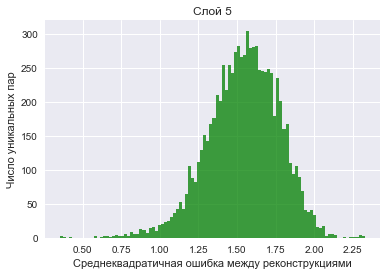

In [52]:
n, bins, patches = plt.hist(x, 100, facecolor='green', alpha=0.75)
plt.title("Слой "+str(layer))
plt.xlabel("Среднеквадратичная ошибка между реконструкциями")
plt.ylabel("Число уникальных пар")
plt.show()

In [53]:
np.mean(x), np.std(x)

(1.5413047, 0.22824515)

In [12]:
layer_list = [0, 2, 5, 7]

In [125]:
for layer in layer_list:
    num_filt = vgg16_c.feature_outputs[layer].data.shape[1]
    decon_maps = []
    
    for filt in range(num_filt):
        decon = vgg16_d(vgg16_c.feature_outputs[layer][:, filt].unsqueeze(1), layer, filt, vgg16_c.pool_indices).data
        decon -= decon.mean()
        decon /= decon.std()
        decon_maps.append(decon)

    dist = np.zeros((num_filt, num_filt), dtype=np.float32)
    for i in range(num_filt):
        for j in range(i):
            dist[i, j] = torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)
            
    with open("reconstructions_" + str(layer) + ".npy", 'wb') as f:
        np.save(f, dist)

In [126]:
cols = 2
rows = len(layer_list)//cols + len(layer_list)%cols

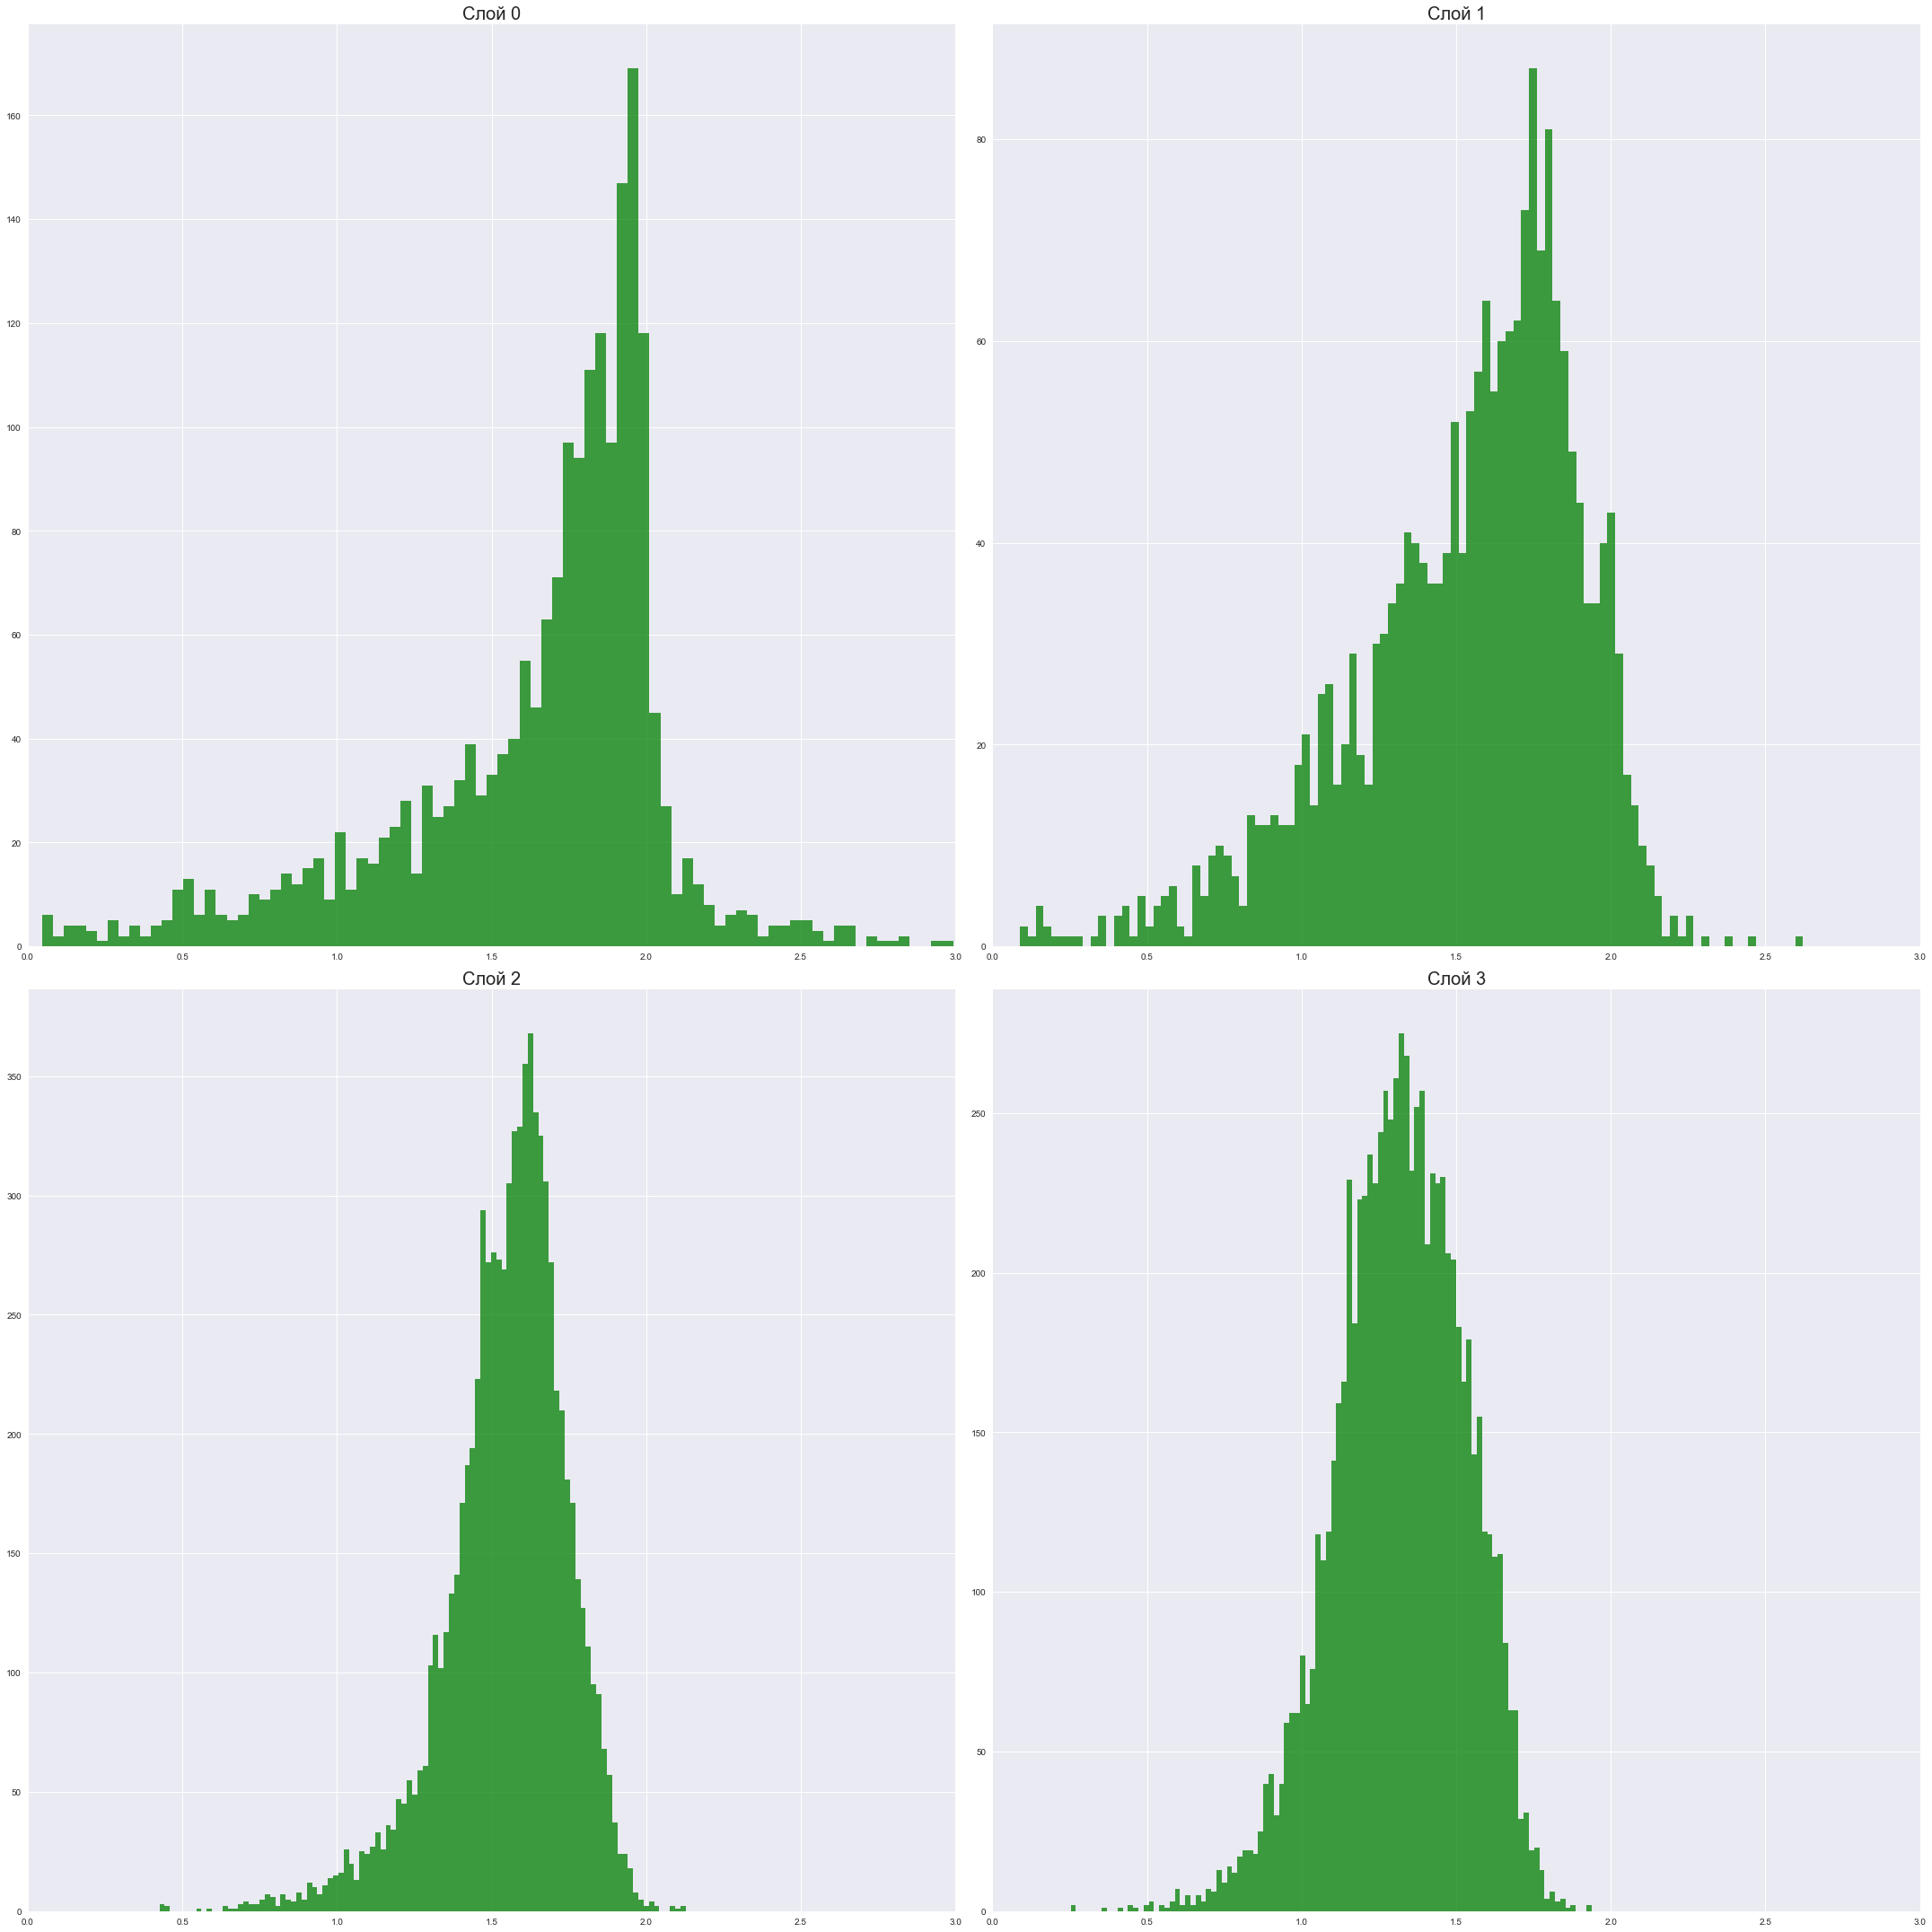

In [127]:
f, axarr = plt.subplots(nrows=rows, ncols=cols,  figsize=(30, 30))

all_sorts = []

i = 0
for row in range(rows):
    for col in range(cols):
        
        dist = None
        with open("reconstructions_" + str(layer_list[i]) + ".npy", 'rb') as f:
            dist = np.load(f)
        sorts = get_sorts(dist)
        x = list(sorts.values())
        all_sorts.append(x)
        
        axarr[row, col].set_title("Слой "+str(i))
        axarr[row, col].title.set_fontsize(20)
        axarr[row, col].hist(x, 100, facecolor='green', alpha=0.75)
        axarr[row, col].set_xlim(0, 3)
        
        i += 1
        
        if i >= len(layer_list):
            break
        
plt.tight_layout()
plt.show()

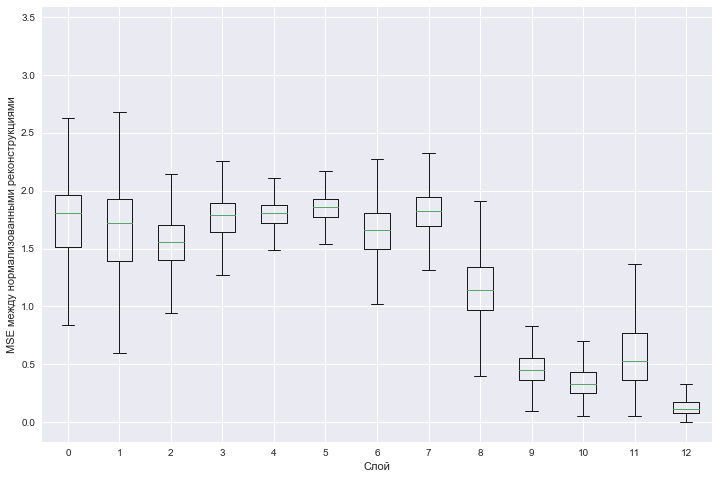

In [58]:
plt.figure(figsize=(12, 8))
plt.boxplot(all_sorts, labels=range(len(layer_list)))
plt.xlabel("Слой")
plt.ylabel("MSE между нормализованными реконструкциями")
plt.show()

In [46]:
#layer_list = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
layer_list = [0, 2, 5, 7]
#layer_list = [0]
#layer = 2
#im = 3

In [47]:
all_filt_means = []
for layer in layer_list:
    mean_dist_mat = None
    
    for batch_idx, batch in enumerate(dataloader):
        if batch_idx > 5:
            break
        print("layer: {} Batch {}:".format(layer, batch_idx))
        datatensor = batch[0]
        img_var = Variable(datatensor.cuda(), requires_grad=False)

        conv_out = vgg16_c.forward(img_var)

        num_filt = vgg16_c.feature_outputs[layer].data.shape[1]
        
        if mean_dist_mat is None:
            mean_dist_mat = np.zeros((num_filt, num_filt), dtype=np.float32)
        
        decon_maps = []

        for filt in range(num_filt):
            decon = vgg16_d(vgg16_c.feature_outputs[layer][:, filt].unsqueeze(1), layer, filt, vgg16_c.pool_indices).data
            #decon -= decon.mean()
            #decon /= decon.std()
            decon_maps.append(decon)

        #dist = np.zeros((num_filt, num_filt), dtype=np.float32)
        for i in range(num_filt):
            for j in range(i):
                mean_dist_mat[i, j] += torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)
                mean_dist_mat[j, i] = mean_dist_mat[i, j]

    mean_dist_mat /= batch_idx

    filt_means = []
    for i in range(num_filt):
        filt_means.append(np.mean(mean_dist_mat[:, i]))
    all_filt_means.append(filt_means)
        
    with open("reconstructions_" + str(layer) + ".npy", 'wb') as f:
        np.save(f, mean_dist_mat)

layer: 0 Batch 0:
layer: 0 Batch 1:
layer: 0 Batch 2:
layer: 0 Batch 3:
layer: 0 Batch 4:
layer: 0 Batch 5:
layer: 2 Batch 0:
layer: 2 Batch 1:
layer: 2 Batch 2:
layer: 2 Batch 3:
layer: 2 Batch 4:
layer: 2 Batch 5:
layer: 5 Batch 0:
layer: 5 Batch 1:
layer: 5 Batch 2:
layer: 5 Batch 3:
layer: 5 Batch 4:
layer: 5 Batch 5:
layer: 7 Batch 0:
layer: 7 Batch 1:
layer: 7 Batch 2:
layer: 7 Batch 3:
layer: 7 Batch 4:
layer: 7 Batch 5:


In [ ]:
layer_to_plot = 0

plt.figure()
plt.hist(all_filt_means[layer_to_plot], len(all_filt_means[layer_to_plot])//5, facecolor='green', alpha=0.75)
plt.show()

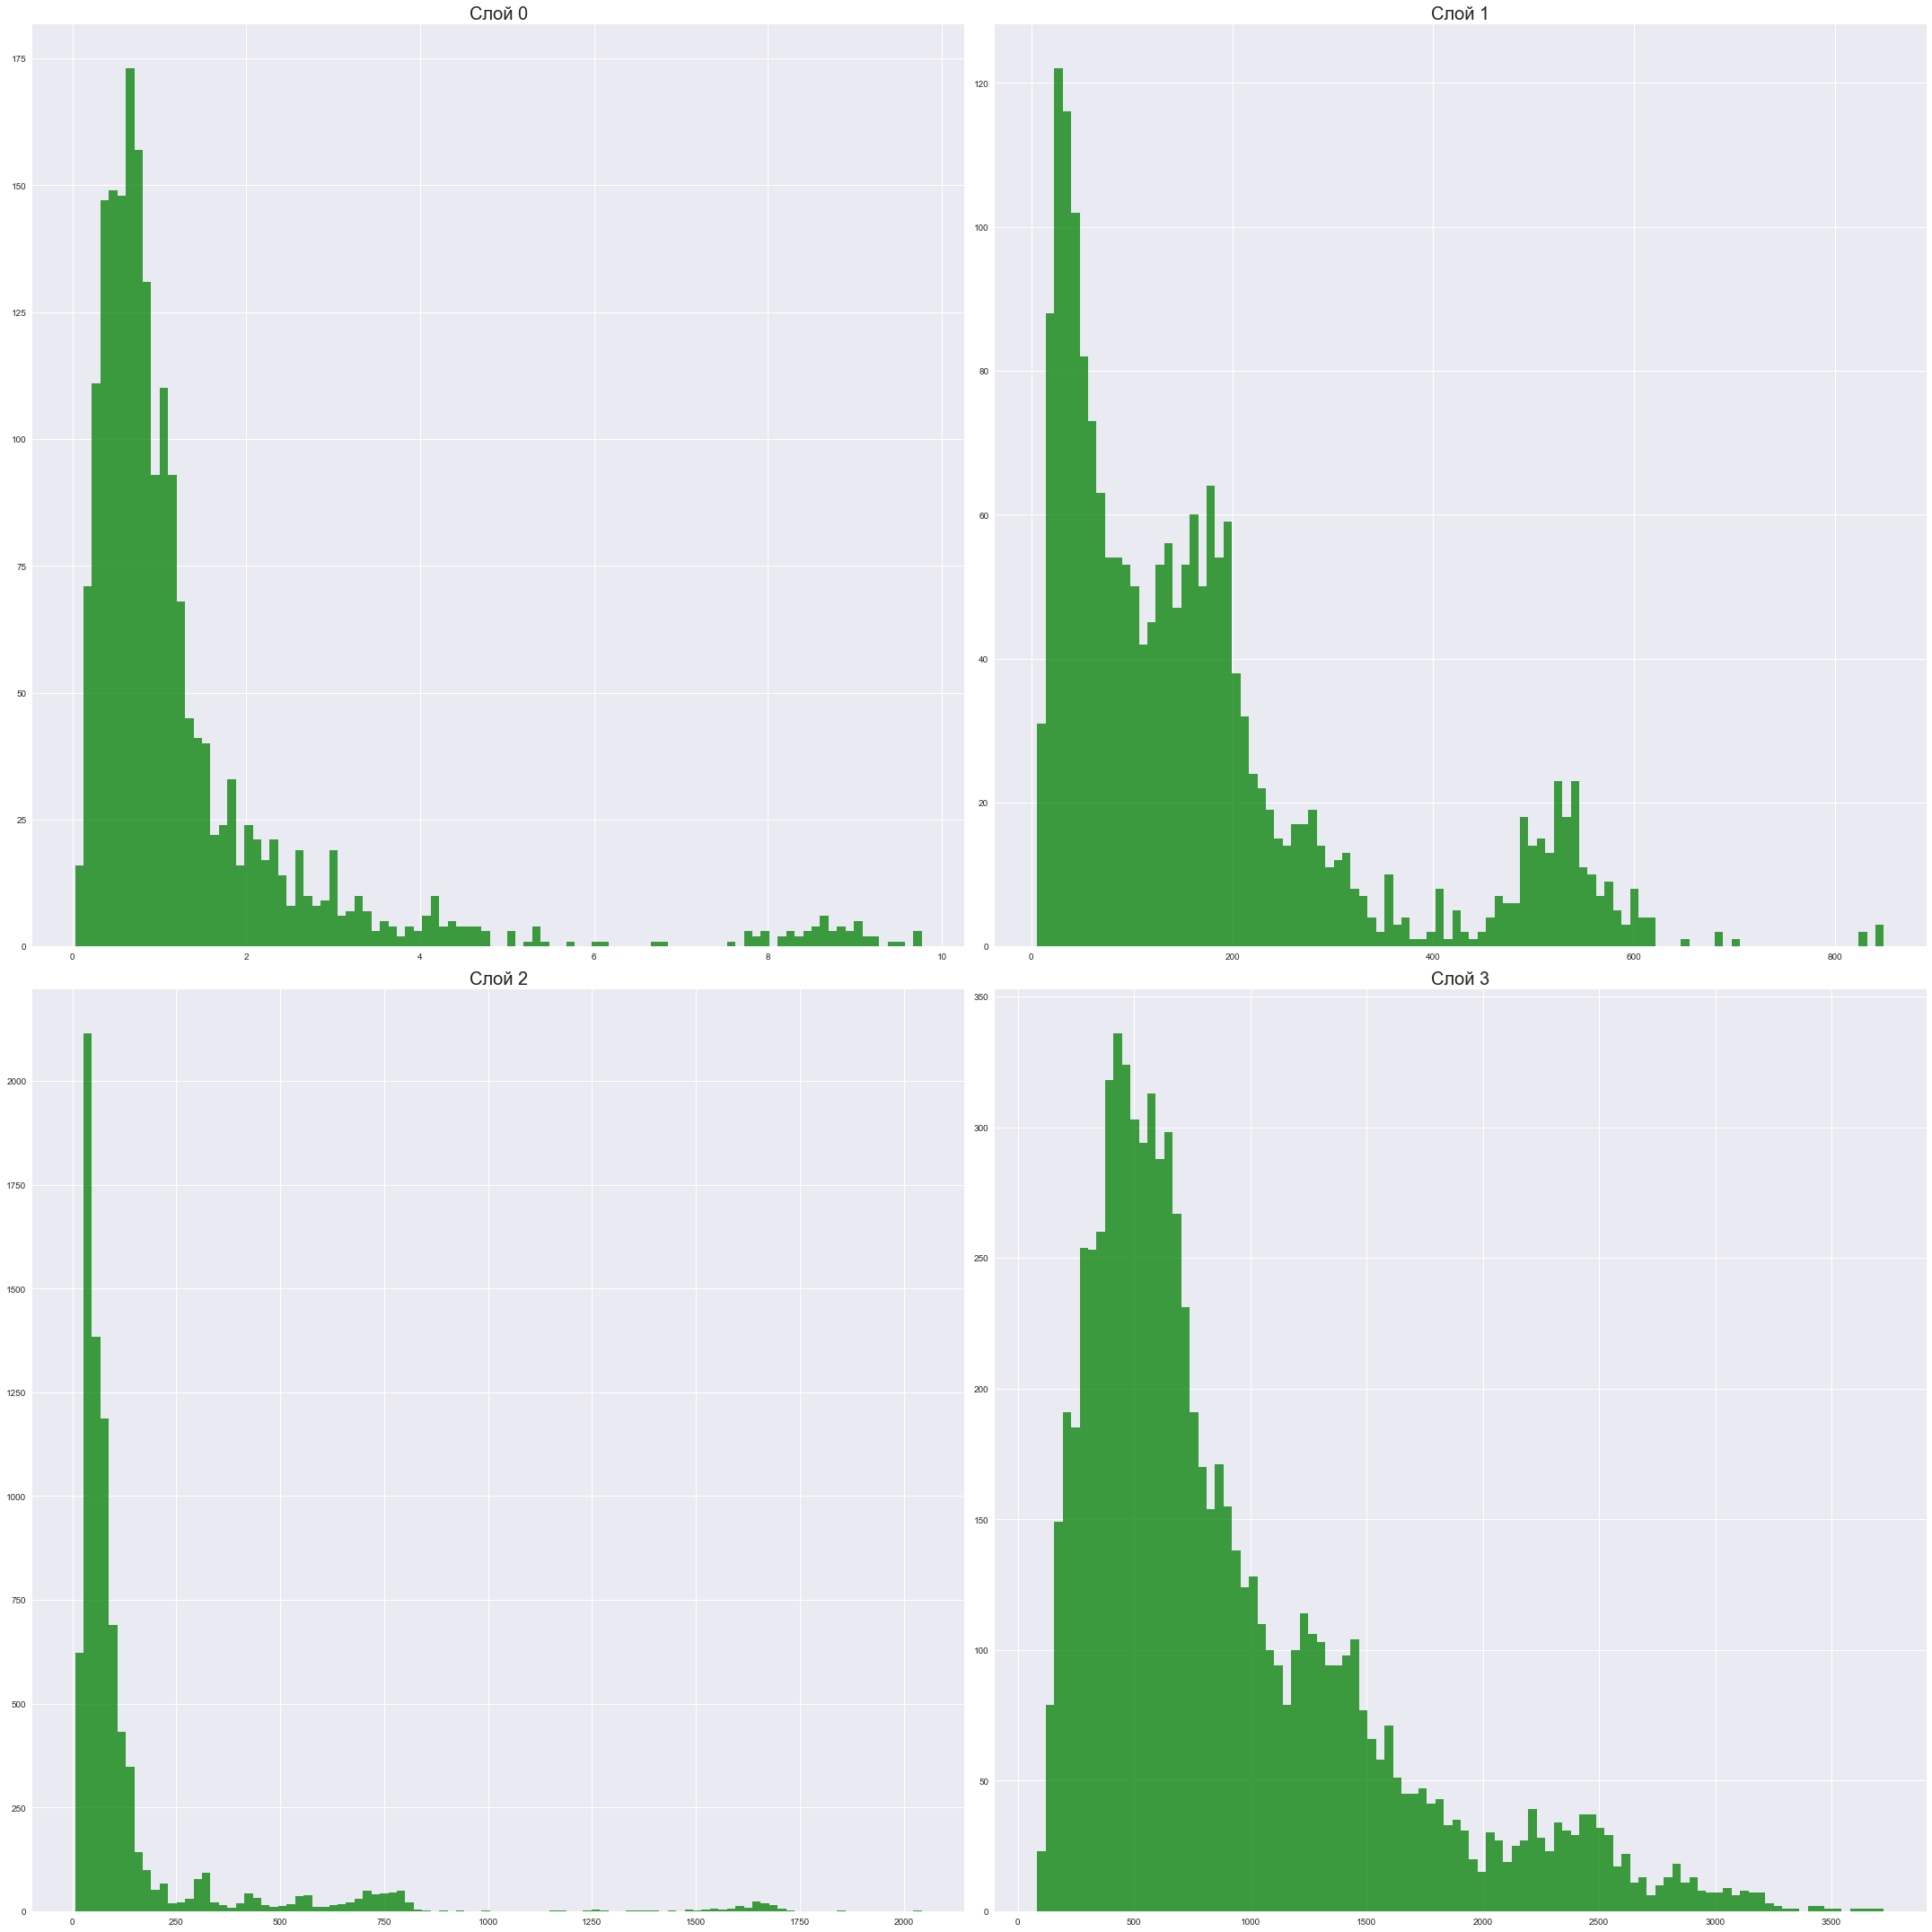

In [51]:
rows=2
cols=2

f, axarr = plt.subplots(nrows=rows, ncols=cols,  figsize=(30, 30))

all_sorts = []

i = 0
for row in range(rows):
    for col in range(cols):
        
        dist = None
        with open("reconstructions_" + str(layer_list[i]) + ".npy", 'rb') as f:
            dist = np.load(f)
        sorts = get_sorts(dist)
        x = list(sorts.values())
        all_sorts.append(x)
        
        axarr[row, col].set_title("Слой "+str(i))
        axarr[row, col].title.set_fontsize(20)
        axarr[row, col].hist(x, 100, facecolor='green', alpha=0.75)
        #axarr[row, col].set_xlim(0, 3)
        
        i += 1
        
        if i >= len(layer_list):
            break
    else:
        continue
    break
        
plt.tight_layout()
plt.show()

In [210]:
vgg16_pretrained.features[2].weight.data.shape

torch.Size([64, 64, 3, 3])

In [254]:
def it(layers, features):
    for i in layers:
        yield i, features[i]
def enumerate_shift(shift, iterable):
    for i, v in enumerate(iterable):
        if i >= shift:
            yield i, v
    

In [191]:
for i, j in it(layers_to_process, vgg16_pretrained.features):
    print(i, j)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [328]:
layers_to_process = [0, 2, 5]
remove_filter_indices = {0: [1,2], 2:[2,3], 5: [3, 4]}
remove_num_filt = {k:len(v) for k, v in remove_filter_indices.items()}
filt_f = lambda l: lambda x: not x in l
indices = {k: list(filter(filt_f(remove_filter_indices[k]), range(v.weight.data.shape[0]))) for k, v in it(layers_to_process, vgg16_pretrained.features)}
indices_in = {k: list(filter(filt_f(remove_filter_indices[layers_to_process[i-1]]), range(v.weight.data.shape[1]))) for i, (k, v) in enumerate_shift(1, it(layers_to_process, vgg16_pretrained.features))}
indices_in[0] = [0, 1, 2]
indices_in[7] = indices[5]
indices[7] = list(range(128))
for i, j in indices_in.items():
    #print(i, remove_num_filt[i], len(indices[i]), len(indices_in[i]))
    print(i, indices_in[i])
    print()

2 [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

5 [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

0 [0, 1, 2]

7 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

In [230]:
remove_filter_indices.items()

dict_items([(0, [1, 2]), (2, [2, 3]), (5, [3, 4])])

In [197]:
vgg16_pretrained.features[0].bias.data.shape

torch.Size([64])

In [177]:
vgg16_pretrained.features[2].weight.data[:, indices, :, :].shape

torch.Size([64, 62, 3, 3])

In [316]:
vgg16_pretrained.features[2].weight.data[indices[2],][:,indices_in[2],].shape

torch.Size([62, 62, 3, 3])

In [329]:
class VGG16_conv_rem(torch.nn.Module):
    def __init__(self, n_classes):
        super(VGG16_conv_rem, self).__init__()
        # VGG16 (using return_indices=True on the MaxPool2d layers)
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(len(indices_in[0]), len(indices[0]), 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(len(indices_in[2]), len(indices[2]), 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(len(indices_in[5]), len(indices[5]), 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(len(indices[5]), 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv5
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True))
        self.feature_outputs = [0]*len(self.features)
        self.pool_indices = dict()

        self.classifier = vgg16_pretrained.classifier
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            print("initializing layer {}: {}".format(i, layer))
            try:
                if i in layers_to_process or i == 7:
                    print("        HERE1: ", i, self.features[i].weight.data.shape)
                    print("        HERE2: ", i, layer.weight.data[indices[i],][:,indices_in[i],].shape)
                    
                    self.features[i].weight.data = layer.weight.data[indices[i],][:,indices_in[i],]
                    self.features[i].bias.data = layer.bias.data[indices[i],]
                else:
                    self.features[i].weight.data = layer.weight.data
                    self.features[i].bias.data = layer.bias.data
            except Exception as e:
                print("    E: ", i, e)
                continue

    def get_conv_layer_indices(self):
        return [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [330]:
x = VGG16_conv_rem(1000)

initializing layer 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        HERE1:  0 torch.Size([62, 3, 3, 3])
        HERE2:  0 torch.Size([62, 3, 3, 3])
initializing layer 1: ReLU (inplace)
    E:  1 'ReLU' object has no attribute 'weight'
initializing layer 2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        HERE1:  2 torch.Size([62, 62, 3, 3])
        HERE2:  2 torch.Size([62, 62, 3, 3])
initializing layer 3: ReLU (inplace)
    E:  3 'ReLU' object has no attribute 'weight'
initializing layer 4: MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    E:  4 'MaxPool2d' object has no attribute 'weight'
initializing layer 5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        HERE1:  5 torch.Size([126, 62, 3, 3])
        HERE2:  5 torch.Size([126, 62, 3, 3])
initializing layer 6: ReLU (inplace)
    E:  6 'ReLU' object has no attribute 'weight'
initializing layer 7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1)